In [160]:
import keras.losses
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt
import tensorflow as tf
from keras import layers
import os

# Project Topic


Explanation: Sentiment analysis is one of the crowning achievements of recent advances in machine learning. In its most naive form, sentiment analysis is a simple binary classification with two possible label outputs, calculated as a function of an input string. In the case that we will explore, the input string is a single movie review, and the corpus of documents is all of the full text movie reviews in the dataset. The basic strategy for sentiment analysis includes drawing inferences and making predictions based on the relative importance and prominence of a word within a sequence or given document against the corpus of all documents. In this report, we will be utilizing unsupervised, supervised, and deep learning methods to estimate sentiment analysis on a corpus of documents.

Our strategy in this report will be to use the tfidf vectorizer from sklearn to create a vocabulary and sparse matrix for each document. Then we will build a supervised model with the Random Forest Classifier, using Randomized Search CV to tune the hyperparameters for both the vectorizer and the Random Forest Classifier as a benchmark. Finally, we will build a multilayer neural network with Keras, that uses our sparse matrix and vocabulary as input, and determines the appropriate label as an output.
Motivation: My motivation is to wield the full spectrum of techniques across unsupervised, supervised, and deep learning that we have learned this semester in a cohesive end-to-end model, and to compare the results between these approaches.

# Data
Source: Kaggle.com "Bag of Words Meets Bags of Popcorn" https://www.kaggle.com/competitions/word2vec-nlp-tutorial/data
Description: The Bag of Words Meets Bags of Popcorn Dataset is the dataset used in an NLP tutorial on Kaggle.com. I have not previously viewed or completed this tutorial and do not intend to use the techniques and methods described in the tutorial in the completion of my project.

The dataset includes three features "id" (categorical), "sentiment" (numerical), and "review" (categorical). There are 75,000 total observations (25,000 train observations, and 50,000 test observations) in the dataset. The train observations are labeled with sentiment 1.0 or 0.0, where a review was scored either >= 7 or < 7 respectively. There are no null values, in the train dataset.

Given we do not have the labels for the test dataset, we will have to use a portion of the train data set for validation purposes, and we will not be able to fully evaluate the efficacy of our model.

In [208]:
class RecommenderSystem:
    def __init__(self, train, test):
        self.ntrain = len(train)
        self.ntest = len(test)
        self.X = pd.concat([trainLabeled, test]).dropna(how='all')
        self.test = np.asarray(self.X[self.ntrain:])

    def vectorize(self, max_features):
        vectorizer = TfidfVectorizer(max_features=max_features)
        Xtfidf = vectorizer.fit_transform(self.X['review'])
        self.vocab = np.asarray(vectorizer.get_feature_names_out())
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(Xtfidf[:self.ntrain], np.asarray(self.X[:self.ntrain]['sentiment']))
        return self
    def fit(self, model):
        self.model = model
        model.fit(self.X_train, self.y_train)
        return self

    def predict(self):
        self.yp = self.model.predict(self.X_test)
        return self

    def score(self):
        return accuracy_score(self.y_test, self.yp)

trainLabeled = pd.read_csv('./data/labeledTrainData.tsv', sep='\t', header=0, quoting=3).set_index('id')
test = pd.read_csv('./data/unlabeledTrainData.tsv', sep='\t', header=0, quoting=3).set_index('id').drop('Unnamed: 2',axis=1)

rm.X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75000 entries, "5814_8" to 35270_0
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sentiment  25000 non-null  float64
 1   review     75000 non-null  object 
dtypes: float64(1), object(1)
memory usage: 1.7+ MB


# Data Cleaning and EDA
Explanation of how and why cleaning is performed:

The cleaning that we need to do on this dataset is limited to the cleaning and parsing of strings, and resulting transformation into a sparse matrix for input into subsequent models. Looking at the reviews, we can see that the text is ascii, however, we will need to make sure that all of the words are lowercase, that all punctuation and special characters are removed, that all stop words are eliminated.

The sklearn vectorizers will perform these transformations for us automatically when we pass our full dataset to the fit_transform function. TFIDF does not remove stop words, however, by setting max_features at any reasonable threshold, we will eliminate those tokens which are most common to all documents in the corpus and thus, least meaningful, implicitly eliminating the stop words for us.

To transform the data into a sparse matrix, we are going to use a textvectorizer that calculates the term frequency, inverse document frequency (TFIDF) of each word in each document. This will produce a vocabulary for us that consists of a vector of length (max_features) where each element of the vector corresponds with a word in our vocabulary. Our vocabulary will be derived from the full set of all reviews (training and test). As we learned in previous assignments, we can derive our vocabulary from the entire corpus of documents, without biasing our model. This is because our TFIDF vectorizer is not aware of the labels associated with each observation, and is merely deriving the relationship between words and documents in the corpus.

We will chose TFIDF over a basic CountVectorizer, given the basic objective of sentiment analysis is identifying the magnitude and direction of each word as it relates to the overall sentiment of the document. A simple word count would be too likely to include words that are frequently used but have low meaning.

In [82]:
pipeline = Pipeline(
    [
        ("vectorizer", TfidfVectorizer()),
        ("est", RandomForestClassifier()),
    ]
)
pipeline

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('est', RandomForestClassifier())])

In [136]:
parameter_grid = {
    "vectorizer__max_features": (5000, 10000,15000,20000),
    "est__n_estimators": ( 100, 200, 300),
    "est__max_depth": (5, 15, 30),
}
rscv = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=parameter_grid,
    n_iter=25,
    n_jobs=-1,
    verbose=1
)
rscv.fit(trainLabeled.review, trainLabeled.sentiment)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                                             ('est',
                                              RandomForestClassifier())]),
                   n_iter=25, n_jobs=-1,
                   param_distributions={'est__max_depth': (5, 15, 30),
                                        'est__n_estimators': (100, 200, 300),
                                        'vectorizer__max_features': (5000,
                                                                     10000,
                                                                     15000,
                                                                     20000)},
                   verbose=1)

In [137]:
df = pd.DataFrame(rscv.cv_results_)

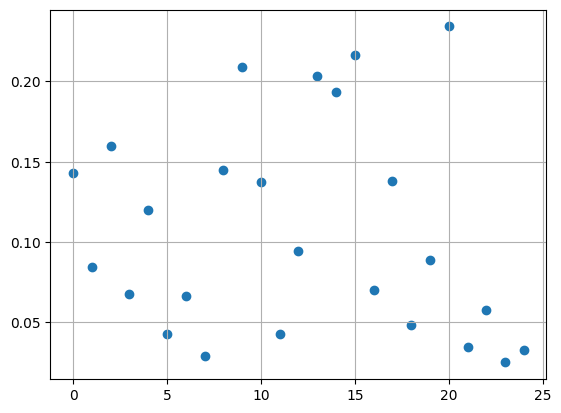

In [138]:
X = df.mean_fit_time
y = df.mean_test_score
plt.scatter(X.index, y/X)
plt.grid()

In [139]:
df.loc[np.argmax(y/X)].params

{'vectorizer__max_features': 15000,
 'est__n_estimators': 100,
 'est__max_depth': 5}

In [140]:
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_vectorizer__max_features,param_est__n_estimators,param_est__max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,5.803449,0.510379,0.618816,0.038915,10000,100,15,"{'vectorizer__max_features': 10000, 'est__n_es...",0.8234,0.8338,0.8248,0.8300,0.8286,0.82812,0.003724,17
1,9.864098,0.870843,0.734909,0.046988,10000,200,15,"{'vectorizer__max_features': 10000, 'est__n_es...",0.8280,0.8338,0.8278,0.8342,0.8366,0.83208,0.003545,12
2,5.104265,0.144178,0.745544,0.051471,5000,200,5,"{'vectorizer__max_features': 5000, 'est__n_est...",0.8096,0.8170,0.8112,0.8180,0.8168,0.81452,0.003426,23
3,12.319468,0.812783,0.896772,0.053672,20000,300,15,"{'vectorizer__max_features': 20000, 'est__n_es...",0.8288,0.8352,0.8352,0.8394,0.8398,0.83568,0.003965,9
4,6.815732,0.148851,0.815252,0.065269,5000,300,5,"{'vectorizer__max_features': 5000, 'est__n_est...",0.8146,0.8154,0.8154,0.8248,0.8242,0.81888,0.004602,19
5,19.782057,1.491703,0.879936,0.035930,15000,200,30,"{'vectorizer__max_features': 15000, 'est__n_es...",0.8316,0.8434,0.8378,0.8468,0.8482,0.84156,0.006136,4
6,12.509974,0.756201,0.733105,0.043120,5000,200,15,"{'vectorizer__max_features': 5000, 'est__n_est...",0.8258,0.8316,0.8274,0.8412,0.8322,0.83164,0.005363,13
7,28.931669,2.169771,0.965643,0.089309,10000,300,30,"{'vectorizer__max_features': 10000, 'est__n_es...",0.8372,0.8436,0.8436,0.8466,0.8460,0.84340,0.003332,2
8,5.723303,0.259110,0.762385,0.055897,20000,100,15,"{'vectorizer__max_features': 20000, 'est__n_es...",0.8232,0.8322,0.8272,0.8342,0.8282,0.82900,0.003868,15
9,3.886933,0.082076,0.633085,0.034436,5000,100,5,"{'vectorizer__max_features': 5000, 'est__n_est...",0.8126,0.8086,0.8136,0.8172,0.8074,0.81188,0.003539,25


In [141]:
for param in sorted(parameter_grid.keys()):
    print(f"{param} : {rscv.best_estimator_.get_params()[param]}")

est__max_depth : 30
est__n_estimators : 300
vectorizer__max_features : 20000


In [178]:
rm = RecommenderSystem(trainLabeled, test)
best_max_depth = rscv.best_estimator_.get_params()['est__max_depth']
best_n_estimators = rscv.best_estimator_.get_params()['est__n_estimators']
best_max_features = rscv.best_estimator_.get_params()['vectorizer__max_features']
rm.vectorize(best_max_features)
forest = RandomForestClassifier(max_depth=best_max_depth,n_estimators=best_n_estimators)
rm.fit(forest).predict().score()

0.84496

In [204]:
inputs = keras.Input(shape=(rm.X_train.shape[1],))

dense = layers.Dense(64, activation="relu")
x = dense(inputs)
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1,activation="sigmoid",name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="movie_reviews")
model.compile(
    optimizer = "adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

model.fit(rm.X_train.todense(), rm.y_train, batch_size=64, epochs=3, validation_data=(rm.X_test.todense(),rm.y_test))

Epoch 1/3
293/293 [==============================] - 1s 4ms/step - loss: 0.3633 - accuracy: 0.8534 - val_loss: 0.2453 - val_accuracy: 0.8982
Epoch 2/3
293/293 [==============================] - 1s 3ms/step - loss: 0.1262 - accuracy: 0.9590 - val_loss: 0.2825 - val_accuracy: 0.8918
Epoch 3/3
293/293 [==============================] - 1s 3ms/step - loss: 0.0515 - accuracy: 0.9864 - val_loss: 0.3791 - val_accuracy: 0.8832


In [205]:
model.predict(rm.X_test[:3])

1/1 [==============================] - 0s 27ms/step


array([[9.9977934e-01],
       [1.5073504e-04],
       [2.5365336e-04]], dtype=float32)

In [206]:
model.summary()

Model: "movie_reviews"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 20000)]           0         
                                                                 
 dense_37 (Dense)            (None, 64)                1280064   
                                                                 
 dense_38 (Dense)            (None, 64)                4160      
                                                                 
 predictions (Dense)         (None, 1)                 65        
                                                                 
Total params: 1284289 (4.90 MB)
Trainable params: 1284289 (4.90 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Tabulated Examples


# Visualizations


# Analysis

# Conclusions and Discussions

# Model building/ Model Choice

# Model Training
Training procedure:
Hyperparameter Tuning:
Train/Test Performance:

# Results and Analysis


## Summary

## Visualizations

## Evaluation Metrics

## Comparison of Results

## Discussion and Conclusion on final results